In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (GridSearchCV, train_test_split)

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import (LinearSVC, SVC)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgbm
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import f1_score
import seaborn
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import re

# Data Partitioning

In [2]:
PRIMARY = pd.read_csv('PRIMARY-Twitter_Stance.csv')
SECONDARY = pd.read_csv('SECONDARY-Reddit_Stance.csv')

# 70% train and 30% test from primary dataset
P_X_train, P_X_test, P_Y_train, P_Y_test = train_test_split(PRIMARY['text'], PRIMARY['label'], test_size = 0.3,
                                                           random_state = 22, stratify = PRIMARY['label'])

# 100% of secondary dataset as test dataset
S_X_test, S_Y_test = SECONDARY['text'], SECONDARY['label']

In [3]:
PRIMARY

,text,label
0,Follow the CDC guidelines. Don’t become a stat...,pro-mitigation
1,Do you agree with CDC guidelines that children...,unclear
2,"So, both #Pharmaceutical companies #lilly and ...",unclear
3,The CDC's guidelines are clear; you just don't...,pro-mitigation
4,CDC Updates School Guidelines For Students Ret...,unclear
...,...,...
1486,.Sprint To Develop A #COVIDVaccine – // https:...,unclear
1487,Here in the U.S. some localities have brought ...,pro-mitigation
1488,Sanitizer &amp; Mask Manufacturers After Russi...,unclear
1489,We are following all CDC guidelines through a ...,pro-mitigation


In [4]:
SECONDARY

,text,label
0,"Just give those people a wide berth, and do w...",pro-mitigation
1,"I would love to know as well. But then, daycar...",unclear
2,Moral people will see it as an easy way to not...,pro-mitigation
3,masking all time as i dont trust variants and ...,pro-mitigation
4,"Not just ""when out"", but when inside something...",pro-mitigation
...,...,...
283,What vaccine. Why is it presumed that a vac wi...,unclear
284,"Nope, you can still wear a mask if you want th...",pro-mitigation
285,> Too bad this was published after my district...,pro-mitigation
286,It's simple either youreally care about the ki...,unclear


In [5]:
print(PRIMARY['label'].value_counts())
# Primary has pretty good amounts of data for each stance. Although, anti-mitgation is quite low
# Also stratified when doing the split, so both splits have about same percentage as the whole data in terms of stances

unclear            715
pro-mitigation     494
anti-mitigation    282
Name: label, dtype: int64


In [6]:
print(SECONDARY['label'].value_counts())
# Secondary have pretty low amounts for anti-mitigation, so prob will have bad accuracy on that stance

pro-mitigation     171
unclear             98
anti-mitigation     19
Name: label, dtype: int64


In [7]:
print('Average length of text...')
print('pro-mitigation', np.mean(PRIMARY.loc[PRIMARY['label'] == 'pro-mitigation'].text.str.len()))
print('pro-mitigation', np.mean(PRIMARY.loc[PRIMARY['label'] == 'anti-mitigation'].text.str.len()))
print('pro-mitigation', np.mean(PRIMARY.loc[PRIMARY['label'] == 'unclear'].text.str.len()))

Average length of text...
pro-mitigation 167.417004048583
pro-mitigation 173.3049645390071
pro-mitigation 147.36363636363637


# Baseline model training

In [8]:
# bag of words
cv = CountVectorizer(stop_words = 'english')
P_X_TRAIN = cv.fit_transform(P_X_train).toarray()
P_X_TEST = cv.transform(P_X_test).toarray()
S_X_TEST = cv.transform(S_X_test).toarray()

P_Y_TRAIN = P_Y_train.astype('category').cat.codes
P_Y_TEST = P_Y_test.astype('category').cat.codes
S_Y_TEST = S_Y_test.astype('category').cat.codes

print('Trying different models and choosing the best one as a baseline...\n')

clf = MultinomialNB()
clf.fit(P_X_TRAIN, P_Y_TRAIN)
P_Y_PRED = clf.predict(P_X_TEST)
print('Multinomial Naive Bayes Accuracy:', clf.score(P_X_TEST, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))

clf = KNeighborsClassifier()
clf.fit(P_X_TRAIN, P_Y_TRAIN)
P_Y_PRED = clf.predict(P_X_TEST)
print('KNeighbors Accuracy:', clf.score(P_X_TEST, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))\

clf = LinearSVC(class_weight = 'balanced', random_state = 22, max_iter = 500)
clf.fit(P_X_TRAIN, P_Y_TRAIN)
P_Y_PRED = clf.predict(P_X_TEST)
print('SVC Accuracy:', clf.score(P_X_TEST, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))

clf = RandomForestClassifier(n_estimators = 222, random_state = 22)
clf.fit(P_X_TRAIN, P_Y_TRAIN)
P_Y_PRED = clf.predict(P_X_TEST)
print('Random Forest Accuracy:', clf.score(P_X_TEST, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))

clf = LogisticRegression(class_weight = 'balanced', random_state = 22, max_iter = 200)
clf.fit(P_X_TRAIN, P_Y_TRAIN)
P_Y_PRED = clf.predict(P_X_TEST)
print('Logistic Regression Accuracy:', clf.score(P_X_TEST, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))

Trying different models and choosing the best one as a baseline...

Multinomial Naive Bayes Accuracy: 0.5066964285714286 | F1 Score: 0.499987942284981
KNeighbors Accuracy: 0.47544642857142855 | F1 Score: 0.44358383338280477
SVC Accuracy: 0.5223214285714286 | F1 Score: 0.5138900557094876
Random Forest Accuracy: 0.5580357142857143 | F1 Score: 0.5053481672312088
Logistic Regression Accuracy: 0.5334821428571429 | F1 Score: 0.5267165910490696


I chose Logistic Regression as my base model due to F1 Score and a decent accuracy.

# Model Evaluation

In [9]:
P_Y_PRED = clf.predict(P_X_TEST)
print('PRIMARY Accuracy:', clf.score(P_X_TEST, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))
S_Y_PRED = clf.predict(S_X_TEST)
print('SECONDARY Accuracy:', clf.score(S_X_TEST, S_Y_TEST), '| F1 Score:', f1_score(S_Y_TEST, S_Y_PRED, average = 'weighted'))

PRIMARY Accuracy: 0.5334821428571429 | F1 Score: 0.5267165910490696
SECONDARY Accuracy: 0.4861111111111111 | F1 Score: 0.5391591035920933


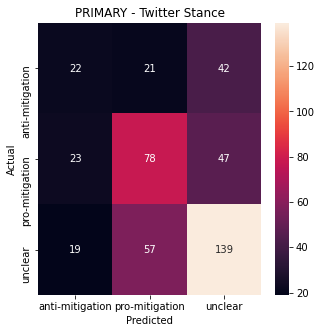

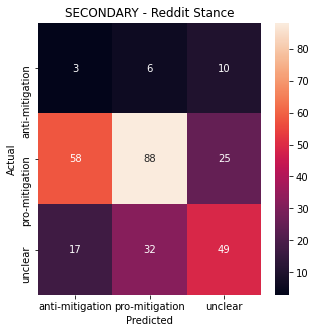

In [10]:
cfn_p = confusion_matrix(P_Y_TEST, P_Y_PRED)
cfn_s = confusion_matrix(S_Y_TEST, S_Y_PRED)

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_p, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('PRIMARY - Twitter Stance')

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_s, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SECONDARY - Reddit Stance')
plt.show()

Hard time classifying anti-mitigation statements accurately, largely due to how low the amount of data we have with that stance.

# Feature Engineering

In [11]:
P_X_TRAIN_FE = P_X_TRAIN[:]
P_X_TEST_FE = P_X_TEST[:]
S_X_TEST_FE = S_X_TEST[:]

PRIMARY Accuracy: 0.5424107142857143 | F1 Score: 0.5352367938186665
SECONDARY Accuracy: 0.4895833333333333 | F1 Score: 0.5394655734157462


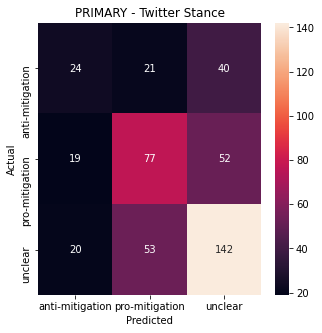

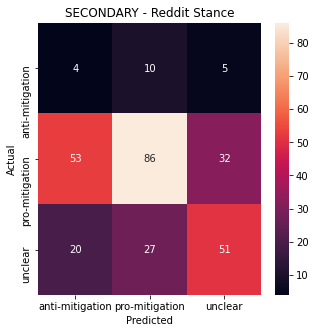

In [12]:
# presence of verb + noun or noun + verb
feature = []
feature_n = []
for t in P_X_train:
    f = 0
    tk = nltk.word_tokenize(t)
    pos = nltk.pos_tag(tk)
    pos = [x[1][:2] for x in pos]
    pos = '-'.join(pos)
    if 'NN-VB' in pos or 'VB-NN' in pos:
        f = 1
    feature.append(f)

P_X_TRAIN_FE = np.c_[P_X_TRAIN_FE, feature] # insert feature

feature = []
feature_n = []
for t in P_X_test:
    f = 0
    tk = nltk.word_tokenize(t)
    pos = nltk.pos_tag(tk)
    pos = [x[1][:2] for x in pos]
    pos = '-'.join(pos)
    if 'NN-VB' in pos or 'VB-NN' in pos:
        f = 1
    feature.append(f)

P_X_TEST_FE = np.c_[P_X_TEST_FE, feature] # insert feature

feature = []
feature_n = []
for t in S_X_test:
    f = 0
    tk = nltk.word_tokenize(t)
    pos = nltk.pos_tag(tk)
    pos = [x[1][:2] for x in pos]
    pos = '-'.join(pos)
    if 'NN-VB' in pos or 'VB-NN' in pos:
        f = 1
    feature.append(f)

S_X_TEST_FE = np.c_[S_X_TEST_FE, feature] # insert feature

clf = LogisticRegression(class_weight = 'balanced', random_state = 24, max_iter = 200, solver = 'liblinear', penalty = 'l1')
clf.fit(P_X_TRAIN_FE, P_Y_TRAIN)

P_Y_PRED = clf.predict(P_X_TEST_FE)
print('PRIMARY Accuracy:', clf.score(P_X_TEST_FE, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))
S_Y_PRED = clf.predict(S_X_TEST_FE)
print('SECONDARY Accuracy:', clf.score(S_X_TEST_FE, S_Y_TEST), '| F1 Score:', f1_score(S_Y_TEST, S_Y_PRED, average = 'weighted'))

cfn_p = confusion_matrix(P_Y_TEST, P_Y_PRED)
cfn_s = confusion_matrix(S_Y_TEST, S_Y_PRED)

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_p, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('PRIMARY - Twitter Stance')

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_s, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SECONDARY - Reddit Stance')
plt.show()

PRIMARY Accuracy: 0.5424107142857143 | F1 Score: 0.5352367938186665
SECONDARY Accuracy: 0.4895833333333333 | F1 Score: 0.5398137091716119


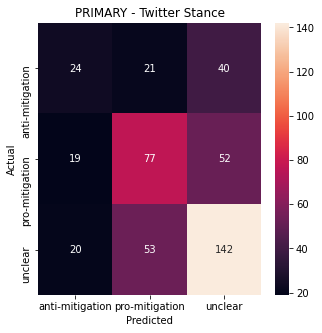

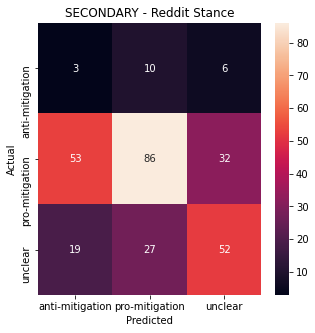

In [13]:
# punctuations, question mark is counted higher because seems more important
punctuations = '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'''

feature = []
for t in P_X_train:
    count = 0
    for w in t.split():
        if w.lower() in punctuations:
            if w == '?':
                count += 3
            else:
                count += 1
    feature.append(count)

P_X_TRAIN_FE = np.c_[P_X_TRAIN_FE, feature] # insert feature

feature = []
for t in P_X_test:
    count = 0
    for w in t.split():
        if w.lower() in punctuations:
            if w == '?':
                count += 3
            else:
                count += 1
    feature.append(count)

P_X_TEST_FE = np.c_[P_X_TEST_FE, feature] # insert feature

feature = []
for t in S_X_test:
    count = 0
    for w in t.split():
        if w.lower() in punctuations:
            if w == '?':
                count += 3
            else:
                count += 1
    feature.append(count)

S_X_TEST_FE = np.c_[S_X_TEST_FE, feature] # insert feature

clf = LogisticRegression(class_weight = 'balanced', random_state = 24, max_iter = 200, solver = 'liblinear', penalty = 'l1')
clf.fit(P_X_TRAIN_FE, P_Y_TRAIN)

P_Y_PRED = clf.predict(P_X_TEST_FE)
print('PRIMARY Accuracy:', clf.score(P_X_TEST_FE, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))
S_Y_PRED = clf.predict(S_X_TEST_FE)
print('SECONDARY Accuracy:', clf.score(S_X_TEST_FE, S_Y_TEST), '| F1 Score:', f1_score(S_Y_TEST, S_Y_PRED, average = 'weighted'))

cfn_p = confusion_matrix(P_Y_TEST, P_Y_PRED)
cfn_s = confusion_matrix(S_Y_TEST, S_Y_PRED)

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_p, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('PRIMARY - Twitter Stance')

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_s, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SECONDARY - Reddit Stance')
plt.show()

PRIMARY Accuracy: 0.5401785714285714 | F1 Score: 0.5335224171988427
SECONDARY Accuracy: 0.4930555555555556 | F1 Score: 0.5410484187954357


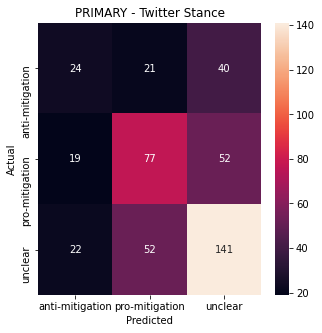

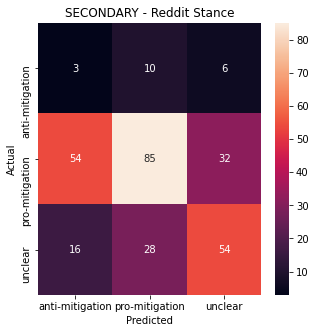

In [14]:
# if has link or hashtag
link_regex = regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
feature = []
for t in P_X_train:
    link_or_url = 1 if len(re.findall(r'#\w+', t)) and len(re.findall(link_regex, t)) else 0
    feature.append(link_or_url)

P_X_TRAIN_FE = np.c_[P_X_TRAIN_FE, feature] # insert feature

feature = []
for t in P_X_test:
    link_or_url = 1 if len(re.findall(r'#\w+', t)) and len(re.findall(link_regex, t)) else 0
    feature.append(link_or_url)

P_X_TEST_FE = np.c_[P_X_TEST_FE, feature] # insert feature

feature = []
for t in S_X_test:
    link_or_url = 1 if len(re.findall(r'#\w+', t)) and len(re.findall(link_regex, t)) else 0
    feature.append(link_or_url)

S_X_TEST_FE = np.c_[S_X_TEST_FE, feature] # insert feature

clf = LogisticRegression(class_weight = 'balanced', random_state = 24, max_iter = 200, solver = 'liblinear', penalty = 'l1')
clf.fit(P_X_TRAIN_FE, P_Y_TRAIN)

P_Y_PRED = clf.predict(P_X_TEST_FE)
print('PRIMARY Accuracy:', clf.score(P_X_TEST_FE, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))
S_Y_PRED = clf.predict(S_X_TEST_FE)
print('SECONDARY Accuracy:', clf.score(S_X_TEST_FE, S_Y_TEST), '| F1 Score:', f1_score(S_Y_TEST, S_Y_PRED, average = 'weighted'))

cfn_p = confusion_matrix(P_Y_TEST, P_Y_PRED)
cfn_s = confusion_matrix(S_Y_TEST, S_Y_PRED)

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_p, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('PRIMARY - Twitter Stance')

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_s, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SECONDARY - Reddit Stance')
plt.show()

['wouldn vaccine year', 'wouldn vaccine year covidvaccine', 'vaccine year covidvaccine', 'ridiculous guidelines', 'year covidvaccine', 'vaccine year', 'cdc ridiculous guidelines', 'people wearing', 'students teachers', 'guidelines required quarantine', 'cdc guidelines required quarantine', 'required quarantine', 'schools make', 'don want kids', 'want kids schools', 'want kids', 'don want kids schools', 'kids schools', 'cdc guidelines said', 'guidelines said', 'travel according', 'cdc guidelines announced', 'travel according updated', 'travel according updated cdc', 'people fully vaccinated travel', 'friday https', 'according updated cdc guidelines', 'herd immunity', 'require masks', 'mask guidelines https', 'following cdc guidelines', 'following cdc', 'masks schools', 'phase ii', 'continue follow', 'vladimir putin', 'updated cdc guidelines', 'updated cdc', 'mask cdc guidelines', 'mask cdc', 'says vaccinated', 'covidvaccine coronavirusvaccine', 'covidvaccine coronavirusvaccine https', '

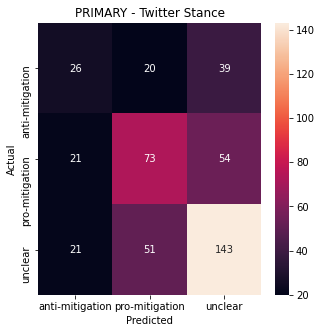

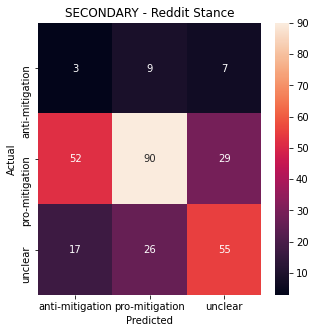

In [15]:
# tf-idf ngrams n > 1 and then find terms/word sequences most correlated with each stance using chi2

#P_X_TRAIN_FE = P_X_TRAIN[:]
#P_X_TEST_FE = P_X_TEST[:]
#S_X_TEST_FE = S_X_TEST[:]

tfidf = TfidfVectorizer(stop_words = 'english', ngram_range = (2,4))
features = tfidf.fit_transform(P_X_train)
labels = P_Y_TRAIN

best_grams = []
for lb in [0,1,2]:
    feat_chi2 = chi2(features, labels == lb)
    indices = np.argsort(feat_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    best_grams.extend(feature_names[-20:])
    #print(feature_names[-15:], '\n')
print(best_grams, '\n')

#print(P_X_TRAIN.shape)
#print(P_X_TEST.shape)
#print(S_X_TEST.shape)

for ngram in best_grams:
    tdidf_best_ngrams_feature = P_X_train.apply(lambda x: 1 if ngram in x else 0)
    P_X_TRAIN_FE = np.c_[P_X_TRAIN_FE, tdidf_best_ngrams_feature] # insert feature
    
    tdidf_best_ngrams_feature = P_X_test.apply(lambda x: 1 if ngram in x else 0)
    P_X_TEST_FE = np.c_[P_X_TEST_FE, tdidf_best_ngrams_feature] # insert feature
    
    tdidf_best_ngrams_feature = S_X_test.apply(lambda x: 1 if ngram in x else 0)
    S_X_TEST_FE = np.c_[S_X_TEST_FE, tdidf_best_ngrams_feature] # insert feature

#print(P_X_TRAIN_FE.shape)
#print(P_X_TEST_FE.shape)
#print(S_X_TEST_FE.shape)

clf = LogisticRegression(class_weight = 'balanced', random_state = 24, max_iter = 200, solver = 'liblinear', penalty = 'l1')
clf.fit(P_X_TRAIN_FE, P_Y_TRAIN)

P_Y_PRED = clf.predict(P_X_TEST_FE)
print('PRIMARY Accuracy:', clf.score(P_X_TEST_FE, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))
S_Y_PRED = clf.predict(S_X_TEST_FE)
print('SECONDARY Accuracy:', clf.score(S_X_TEST_FE, S_Y_TEST), '| F1 Score:', f1_score(S_Y_TEST, S_Y_PRED, average = 'weighted'))

cfn_p = confusion_matrix(P_Y_TEST, P_Y_PRED)
cfn_s = confusion_matrix(S_Y_TEST, S_Y_PRED)

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_p, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('PRIMARY - Twitter Stance')

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_s, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SECONDARY - Reddit Stance')
plt.show()

The best feature engineering I got was: presence of VB+NN or vice versa + # of punctuations with emphasis on ? + presence of link/hashtag + top ngrams correlated with stance found using chi2

# Model Evaluation

PRIMARY Accuracy: 0.5401785714285714 | F1 Score: 0.5339963221060782
SECONDARY Accuracy: 0.5138888888888888 | F1 Score: 0.5634592735287179


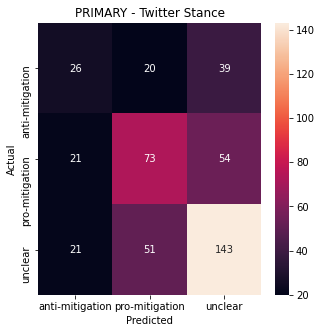

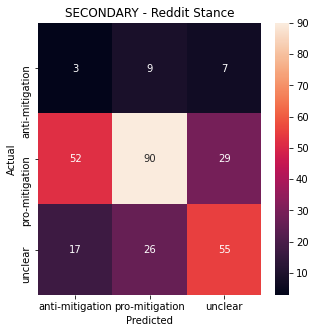

In [16]:
P_Y_PRED = clf.predict(P_X_TEST_FE)
print('PRIMARY Accuracy:', clf.score(P_X_TEST_FE, P_Y_TEST), '| F1 Score:', f1_score(P_Y_TEST, P_Y_PRED, average = 'weighted'))
S_Y_PRED = clf.predict(S_X_TEST_FE)
print('SECONDARY Accuracy:', clf.score(S_X_TEST_FE, S_Y_TEST), '| F1 Score:', f1_score(S_Y_TEST, S_Y_PRED, average = 'weighted'))

cfn_p = confusion_matrix(P_Y_TEST, P_Y_PRED)
cfn_s = confusion_matrix(S_Y_TEST, S_Y_PRED)

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_p, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('PRIMARY - Twitter Stance')

fig, ax = plt.subplots(figsize=(5,5))
seaborn.heatmap(cfn_s, annot = True, fmt = 'd', xticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'],
               yticklabels = ['anti-mitigation', 'pro-mitigation', 'unclear'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('SECONDARY - Reddit Stance')
plt.show()